# Are mice are generalising structure?

To test this idea compare performance of line/loop and loop/loop mice on loop graphs. The prediction is that mice in the line/loop group, running on the line graph will go around the incorrect direction more often than the loop/loop mice.




In [7]:
%matplotlib inline
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn
import scipy.stats as stt
seaborn.set(font_scale=2,style='ticks')
import os
import re
from skimage import measure

import sys
import itertools
import networkx as nx
sys.path.append("/Users/Yves/Documents/Code/structural_knowledge/packages/")

In [8]:
def make_matrix_from(maze):
    
    def in_maze(s):
        return s[0] >= 0 and s[0] < maze.shape[0] and s[1] >= 0 and s[1] < maze.shape[1]

    def is_free(s):
        return maze[s[0],s[1]] == 1

    def valid_state(s):
        return in_maze(s) and is_free(s)
    
    states = [np.array(s) for s in itertools.product(range(maze.shape[0]), range(maze.shape[1])) if maze[s[0], s[1]] == 1]
    adja = np.eye(len(states))
    idx = np.zeros(maze.shape, dtype=np.int)
    c = 0
    #for each x coordinate
    for i in range(maze.shape[0]):
        #for each y coordinate
        for j in range(maze.shape[1]):
            if maze[i, j] == 0:
                continue
            idx[i, j] = c
            c += 1
    
    for i, state in enumerate(states):
        possible_next_states = [state + d for d in np.array([[1,0],[-1,0],[0,1],[0,-1]])]
        filtered = list(filter(valid_state, possible_next_states))
        for f in filtered:
            adja[i, idx[f[0], f[1]]] = 1
            adja[idx[f[0], f[1]], i] = 1
    return adja, idx

In [296]:
M = np.ones([9,9])
all_labels = measure.label(M)
M[np.random.randint(0,9),np.random.randint(0,9)] = 0


In [297]:
for _ in range(30):
    Mdash = M.copy()
    Mdash[np.random.randint(0,9),np.random.randint(0,9)] = 0
    all_labels = measure.label(Mdash,connectivity=1)
    if len(np.unique(all_labels))<=2:
        M = Mdash
        

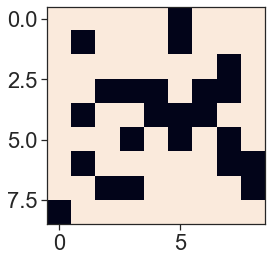

In [298]:
plt.imshow(M)

In [11]:

hairpin = np.zeros([41,42])

In [127]:
xr = 1
for i in range(0,21):
    if np.remainder(i,2)==0:
        hairpin[:,i*2:(i+1)*2] = 1
        xr += 1
        if (i+1)<hairpin.shape[1]:
            if xr%2==0:
                hairpin[-2:,(i+1)*2:(i+2)*2] = 1
            else:
                hairpin[:2,(i+1)*2:(i+2)*2] = 1
        #hairpin[i+1,]

In [129]:
M = hairpin.copy()

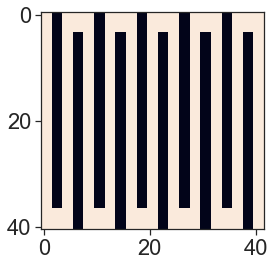

In [294]:
plt.imshow(hairpin)

In [202]:
adj,idx_mtx = make_matrix_from(M)
#adj[np.diag_indices_from(adj)] = 0
T = adj/np.sum(adj,axis=0)

In [284]:
gamma = 0.4
SR = np.linalg.inv(np.eye(T.shape[0]) - gamma * T)

In [285]:

def eigdecomp(M):
    E, V = np.linalg.eig(M)
    idx = np.argsort(E)[::-1]
    return V[:, idx[:]].astype(float), E[idx]

def vec2maze(vec, maze):
    vec_iter = iter(vec)
    res = []
    walls = []
    for i in range(maze.shape[0]):
        for j in range(maze.shape[1]):
            if maze[i, j] == 1:
                res.append(next(vec_iter))
            else:
                res.append(0)
    return np.array(res).reshape(maze.shape)

def plot_eigvecs(eig_vecs, maze, filename=None, figsize=(15,15),nplot=16):
    
    
    plt.figure(figsize=figsize)
    grid_size = int(np.ceil(np.sqrt(nplot)))
    for i in range(nplot):
        if i >= grid_size**2:
            break
        ax = plt.subplot(grid_size, grid_size, i+1)
        ax.matshow(vec2maze(eig_vecs[:, i+1], maze), cmap='RdBu_r',interpolation='None')
        ax.axes.get_xaxis().set_ticks([])
        ax.axes.get_yaxis().set_ticks([])
        plt.grid(False)
    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename, bbox_inches='tight')
    plt.show()

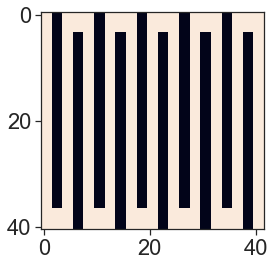

In [286]:
plt.imshow(M)

In [287]:
ixs = np.sort(np.concatenate([np.arange(0,42,4),np.arange(1,42,4)]))

In [288]:
ixs

array([ 0,  1,  4,  5,  8,  9, 12, 13, 16, 17, 20, 21, 24, 25, 28, 29, 32,
       33, 36, 37, 40, 41])

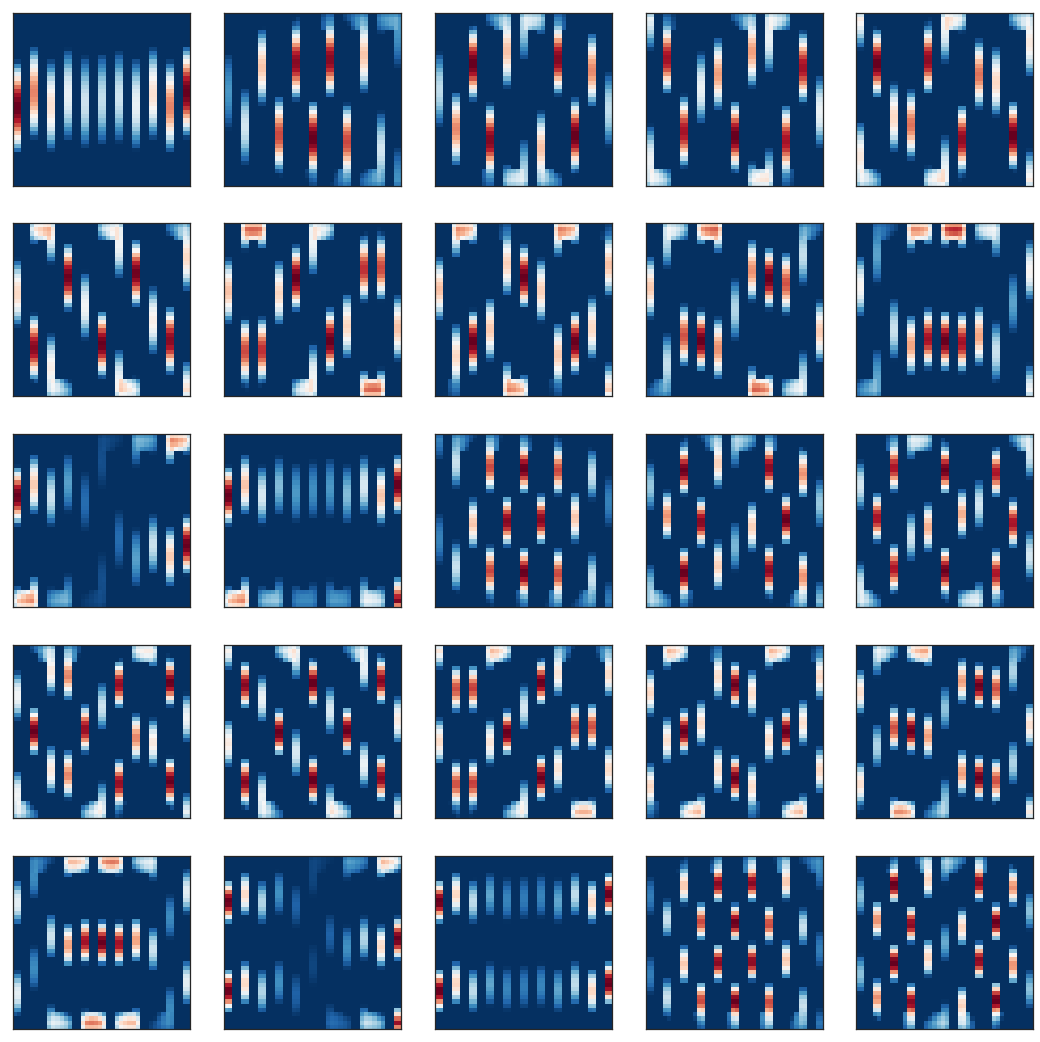

In [290]:
V, E = eigdecomp(SR)
V[V < 0] = 0
#Vs = V[:,np.argsort(E)]
plot_eigvecs(V[:,21:],M,nplot=25)

In [270]:
cc = np.zeros([11,11])
for i in range(22,120):
    tmp = np.corrcoef(vec2maze(V[:,i],M)[:,::4].T)
    if np.all(np.isfinite(tmp)):
        cc += tmp#/np.abs(E[i])

In [271]:
vec2maze(V[:,i],M)[:,::4].shape

(41, 11)

In [272]:
cc.shape

(11, 11)

In [273]:
V.shape

(982, 982)

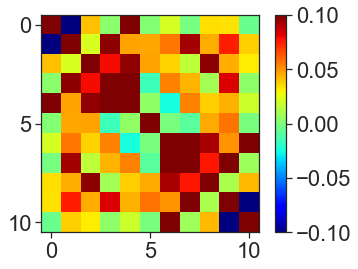

In [274]:
plt.imshow(cc/100.,interpolation='None',vmin=-.1,vmax=.1,cmap='jet')
plt.colorbar()

In [199]:
cc /= 100.

In [200]:
cc.shape

(11, 11)

In [201]:
plt.imshow(np.corrcoef(V[:,np.argsort(E)[::-1]][0].reshape(-1,40)[:,::2]))
plt.colorbar()

ValueError: cannot reshape array of size 982 into shape (40)

In [ ]:
def make_hex_world(nx=6,ny=6):
    
    """ Make a hex world that is nx by ny in size """
    